## Load Data

In [25]:
import json
import numpy as np
import pandas as pd
import os

In [26]:
path = '/home/mlb/res/stock/twse/json/'
filename = [] #json資料夾下所有檔案名稱(YYYY-MM-DD.json)
DF_list = []  #YYYY-MM-DD

for i in os.listdir(path):
    filename.append(i)
    DF_list.append(i[:-5])
filename = sorted(filename)
DF_list = sorted(DF_list)

In [33]:
#------------Stored testing data---------------
files_recent = {}
fr_list = [DF_list[-5],DF_list[-4],DF_list[-3],DF_list[-2],DF_list[-1]]
count = 5
for i in fr_list:
    with open(path+i+'.json') as f:
        symbol_f = json.load(f)
    files_recent[i] = symbol_f
    f.close
#'''
#for i in range(day_index-count,day_index):
#    fr_list.append(filename[i][:-5])
#    with open(path+filename[i]) as f:
#        symbol_f = json.load(f)
#    files_recent[filename[i][:-5]] = symbol_f
#    f.close
#'''
print(fr_list)

['2018-10-05', '2018-10-08', '2018-10-09', '2018-10-11', '2018-10-12']


In [34]:
Stock_sym = [sym for sym in files_recent[fr_list[-1]].keys()]
Stock_sym.remove('id')
New_sym = []
Stock_feature = []
Close = []
Open = []
#Volume = []
#C = []
#O = []

for symbol in Stock_sym:
    tmp = []
    for i in range(0,count):
        if symbol not in files_recent[fr_list[-1-i]].keys():
            break
        for attr in ['adj_close','close','high','low','open','volume']: #['adj_close','close','high','low','open','volume']:
            if files_recent[fr_list[-1-i]][symbol][attr] == None or files_recent[fr_list[-1-i]][symbol][attr] == 'NULL':
                break
            #if attr == 'close':
            #    C.append(float(files_recent[fr_list[-1-i]][symbol]['close']))
            #if attr == 'open':
            #    O.append(float(files_recent[fr_list[-1-i]][symbol]['open']))
            #if attr != 'close':
            tmp.append(float(files_recent[fr_list[-1-i]][symbol][attr]))
                
    if len(tmp) != 30:
        continue
    if files_recent[fr_list[-1]][symbol]['close'] != None and files_recent[fr_list[-1]][symbol]['close'] != 'NULL':
        Stock_feature.append(tmp)
        New_sym.append(symbol)
        Close.append(float(files_recent[fr_list[-1]][symbol]['close']))
        Open.append(float(files_recent[fr_list[-1]][symbol]['open']))

In [43]:
#print(len(Stock_feature))
#print(len(New_sym))
#print(len(Close))
#print(len(Open))

In [36]:
New_sym = np.array(New_sym)
recent_days = np.array(Stock_feature)
close_today = np.array(Close)
stock_open = np.array(Open)

np.save('output/recent_days', recent_days)
np.save('output/close_today', close_today)
np.save('output/stock_open', stock_open)
np.save('output/New_sym', New_sym)

## 取三個月的時間作為Trainning Data

In [171]:
#-----------Stored trainning data--------------
#fro = filename.index('2018-07-04.json')
to = filename.index('2018-10-04.json')
count1 = 90

DF_list = [filename[d][:-5] for d in range(to-count1+1,to+1)]
DF = {}
for i in range(to-count1+1,to+1):
    with open(path+filename[i]) as f:
        symbol_f = json.load(f)
    DF[filename[i][:-5]] = symbol_f
    f.close()

In [177]:
stock_feature = []
new_sym = []
pre_close =[]

for i in range(5, len(DF_list)):
    stock_list = list(DF[DF_list[i]].keys())
    stock_list.remove('id')
    

    for stock in stock_list:  
        tmp = []   
        for j in range(0, 5):
            if stock not in DF[DF_list[i-j-1]].keys():
                break
            for attr in ['adj_close','close','high','low','open','volume']:
                if DF[DF_list[i-j-1]][stock][attr] == None or DF[DF_list[i-j-1]][stock][attr] == 'NULL':
                    break
                #if attr != 'close':
                tmp.append(float(DF[DF_list[i-j-1]][stock][attr]))
            
            
        if len(tmp) != 25:
            continue
            
        if DF[DF_list[i]][stock]['close'] != 'NULL' and DF[DF_list[i]][stock]['close'] != None:
            #ans = 1 if float(content[day_list[i+1]][stock]['close']) - float(content[day_list[i]][stock]['close']) > 0 else 0           
            new_sym.append(stock)
            stock_feature.append(tmp)
            pre_close.append(float(DF[DF_list[i]][stock]['close']))

In [146]:
print(len(pre_close))
print(len(stock_feature))
print(len(new_sym))

468621
468621
468621


In [147]:
new_sym = np.array(new_sym)
X = np.array(stock_feature)

Y = np.array(pre_close)
row = int(round(0.9*len(new_sym)))
X_train = X[:row]
Y_train = Y[:row]
X_test = X[row:]
Y_test = Y[row:]

In [148]:
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

421759 421759
46862 46862


In [149]:
np.save('output/X_train_181004.npy', X_train)
np.save('output/Y_train_181004.npy', Y_train)
np.save('output/X_test_181004.npy', X_test)
np.save('output/Y_test_181004.npy', Y_test)

## Testing Model & Validation

In [150]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import time
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

In [151]:
X_train = np.load('output/X_train_181004.npy')
Y_train = np.load('output/Y_train_181004.npy')
X_test = np.load('output/X_test_181004.npy')
Y_test = np.load('output/Y_test_181004.npy')

In [152]:
t0 = time.time()
clf = GradientBoostingRegressor().fit(X_train, Y_train)
#clf = SVR(C=5, gamma=0.04).fit(X_train, Y_train)
GBR_fit = time.time()-t0

In [153]:
#------Save Model-----------

#存Model
joblib.dump(clf, 'output/model/clf_GBR_181004.pkl')

['output/model/clf_GBR_181004.pkl']

In [154]:
#讀取Model
clf = joblib.load('output/model/clf_GBR_181004.pkl')

In [155]:
t1 = time.time()
y_pre = clf.predict(X_test)
GBR_predict = time.time()-t1

In [156]:
print(mean_squared_error(Y_test, y_pre)) 
print(mean_absolute_error(Y_test, y_pre))

1.3453623806501562
0.30888111647879496


In [168]:
print(Y_test[:20])
print(y_pre[:20])

[ 2.1   1.35  0.59  1.57  0.83  0.88  1.55 11.2   0.52  0.2   1.01  1.36
 17.9   0.35 29.3   2.12  0.86  0.3   0.47  1.11]
[ 1.81912886  1.51342627  0.61911984  1.71340128  0.79879448  0.99289007
  1.54426515 10.27991543  0.61911984  0.31100414  0.91812312  1.45111238
 16.80285208  0.4204853  27.5791659   2.03344693  0.79879448  0.38046822
  0.51683514  1.07670359]


In [157]:
clf.score(X_test, Y_test)

0.9995051042416492

In [158]:
import matplotlib.pyplot as plt

In [159]:
print(y_pre)
print(Y_test)

[1.81912886 1.51342627 0.61911984 ... 0.79411567 0.90600747 1.05675139]
[2.1  1.35 0.59 ... 0.78 0.74 1.04]


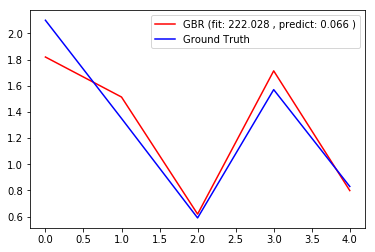

In [176]:
l1 = plt.plot(y_pre[:5], c='r', label='GBR (fit: %.3f , predict: %.3f )' %(GBR_fit, GBR_predict))
#plt.hold(True)
l2 = plt.plot(Y_test[:5], c='b', label='Ground Truth')
plt.legend()
#plt.xticks([1,2,3,4])

## Load Model & Prediction

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

clf = joblib.load('output/model/clf_GBR_181004.pkl')
x_predicted = np.load('output/recent_days.npy')
y_pred = clf.predict(x_predicted)

print(mean_squared_error(y_today, y_pred)) 
print(mean_absolute_error(y_today, y_pred))

0.5311866841955883
0.2038629759426844


In [42]:
np.save('output/y_pred.npy', y_pred)

## Make Decision

In [47]:
import sys
New_sym = np.load('output/New_sym.npy')
open_today = np.load('output/stock_open.npy')
y_today = np.load('output/close_today.npy')
y_pred = np.load('output/y_pred.npy')
icon = {}
decision = []

for i in range(0, len(New_sym)):
    if float((y_pred[i]-y_today[i])/y_today[i]) >= 0.07:
        icon['code'] = New_sym[i]
        icon['type'] = 'buy'
        icon['weight'] = 1
        icon['life'] = 5
        o = open_today[i]
        icon['open_price'] = o
        icon['close_high_price'] = o + float(o*0.03)
        icon['close_low_price'] = o - float(o*0.1)
        decision.append(icon)
        icon = {}
    elif float((y_pred[i]-y_today[i])/y_today[i]) <= -0.1:
        icon['code'] = New_sym[i]
        icon['type'] = 'short'
        icon['weight'] = 1
        icon['life'] = 3
        o = open_today[i]
        icon['open_price'] = o
        icon['close_high_price'] = o + float(o*0.03)
        icon['close_low_price'] = o - float(o*0.1)
        decision.append(icon)
        icon = {}
#Decision[sys.argv[1]] = decision
#print(decision)

with open('../commit/'+sys.argv[1]+'_'+sys.argv[2]+'.json','w') as f:
    json.dump(decision, f, indent=4)    
    #f.write(out)
#print('../commit/'+Day_list[-1][:-5]+'_'+Day_list[-1][:-5]+'.json','w')

FileNotFoundError: [Errno 2] No such file or directory: '../commit/-f_/home/mlb/users/ex4587/.local/share/jupyter/runtime/kernel-5480966f-7947-48f2-bb02-3c602c544345.json.json'